In [105]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import preprocessing
import seaborn as sns

In [106]:
df2 = pd.read_csv("deliveries_2008-2024.csv",low_memory=False)

In [107]:
df2.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NA,NA,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,NA,NA,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NA,NA,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,NA,NA,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,NA,NA,NaN


In [108]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   match_id                      260920 non-null  int64 
 1   inning                        260920 non-null  int64 
 2   batting_team                  260920 non-null  object
 3   bowling_team                  260920 non-null  object
 4   over                          260920 non-null  int64 
 5   ball                          260920 non-null  int64 
 6   batter                        260920 non-null  object
 7   bowler                        260920 non-null  object
 8   non_striker                   260920 non-null  object
 9   batsman_runs                  260920 non-null  int64 
 10  extra_runs                    260920 non-null  int64 
 11  total_runs                    260920 non-null  int64 
 12  extras_type                   260920 non-null  object
 13 

In [109]:
df2.isnull().sum()

,0
match_id,0
inning,0
batting_team,0
bowling_team,0
over,0
ball,0
batter,0
bowler,0
non_striker,0
batsman_runs,0


# **Feature Engineering / Data Preparation**

In [110]:
# Preprocess the ball-by-ball data to predict the final score of an inning
df2.columns = df2.columns.str.strip()
final_score_per_inning = df2.groupby(['match_id', 'inning', 'over']).agg(
    runs_per_over=('total_runs', 'sum'),
    wickets_per_over=('is_wicket', 'sum')
).reset_index()

final_score_per_inning.head(10)

,match_id,inning,over,runs_per_over,wickets_per_over
0,335982,1,0,3,0
1,335982,1,1,18,0
2,335982,1,2,6,0
3,335982,1,3,23,0
4,335982,1,4,10,0
5,335982,1,5,1,1
6,335982,1,6,7,0
7,335982,1,7,5,0
8,335982,1,8,4,0
9,335982,1,9,10,0


In [111]:
# Create features like “strike rate” or “bowler economy rate” from this data
#Strike rate for batters
batting_score = df2.groupby('batter').agg(
    total_runs=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count')  # assumes each row = 1 ball
).reset_index()
batting_score['strike_rate'] = batting_score['total_runs'] / (batting_score['balls_faced'] * 100)
batting_score.head()

,batter,total_runs,balls_faced,strike_rate
0,A Ashish Reddy,280,196,0.014286
1,A Badoni,634,505,0.012554
2,A Chandila,4,7,0.005714
3,A Chopra,53,75,0.007067
4,A Choudhary,25,20,0.012500


In [112]:
# Economy rate for bowlers
bowler_performance = df2.groupby('bowler').agg(
    runs_conceded=('total_runs', 'sum'),
    balls_bowled=('ball', 'count')
).reset_index()

bowler_performance['overs'] = bowler_performance['balls_bowled'] / 6

bowler_performance['economy_rate'] = bowler_performance['runs_conceded'] / bowler_performance['overs']

bowler_performance.head()

,bowler,runs_conceded,balls_bowled,overs,economy_rate
0,A Ashish Reddy,400,270,45.000000,8.888889
1,A Badoni,37,25,4.166667,8.880000
2,A Chandila,245,234,39.000000,6.282051
3,A Choudhary,144,108,18.000000,8.000000
4,A Dananjaya,47,25,4.166667,11.280000


In [207]:
#Build a dataset where each row represents an over.
columns = ['Bowler', 'Batsman', 'Over Number', 'Ball 1', 'Ball 2', 'Ball 3', 'Ball 4', 'Ball 5', 'Ball 6']
df = pd.DataFrame(columns=columns)
over_data = [
    ['Bowler A', 'Batsman X', 1, 1, 0, 4, 0, 1, 2],
    ['Bowler B', 'Batsman Y', 2, 1, 4, 0, 0, 6, 1],
    ['Bowler A', 'Batsman X', 3, 0, 1, 6, 4, 0, 1],
    ['Bowler B', 'Batsman Y', 4, 2, 0, 0, 6, 1, 2],
]

# Convert the list of lists to a DataFrame
df = pd.DataFrame(over_data, columns=columns)
df.head()

,Bowler,Batsman,Over Number,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6
0,Bowler A,Batsman X,1,1,0,4,0,1,2
1,Bowler B,Batsman Y,2,1,4,0,0,6,1
2,Bowler A,Batsman X,3,0,1,6,4,0,1
3,Bowler B,Batsman Y,4,2,0,0,6,1,2


In [208]:
df['Runs_per_over'] = df['Ball 1'] + df['Ball 2'] + df['Ball 3'] + df['Ball 4'] + df['Ball 5'] + df['Ball 6']
df.head()

,Bowler,Batsman,Over Number,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,Ball 6,Runs_per_over
0,Bowler A,Batsman X,1,1,0,4,0,1,2,8
1,Bowler B,Batsman Y,2,1,4,0,0,6,1,12
2,Bowler A,Batsman X,3,0,1,6,4,0,1,12
3,Bowler B,Batsman Y,4,2,0,0,6,1,2,11


<Axes: ylabel='batsman_runs'>

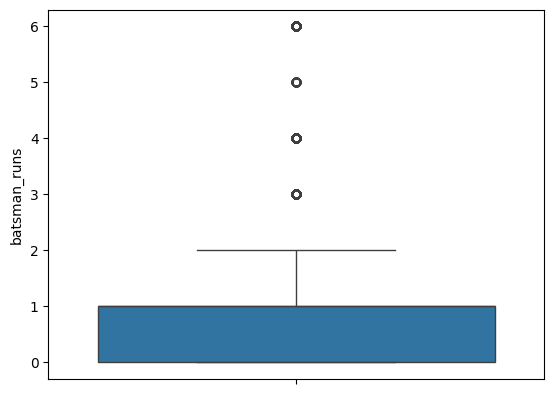

In [115]:
# Detect and handle outliers in batsman_runs or total_runs
sns.boxplot(df2['batsman_runs'])

In [116]:
#Engineer a feature that captures momentum (e.g., runs scored in the last 2 overs). How would you implement it in Pandas?
# Function to calculate runs in last 2 overs
def calculate_runs_last_2_overs(df2):
    df2['last_2_overs_runs'] = 0
    innings = df2['inning'].unique()
    for inning in innings:
        inning_data = df2[df2['inning'] == inning]
        max_over = inning_data['over'].max()
        last_2_overs_data = inning_data[(inning_data['over'] >= max_over - 1) & (inning_data['over'] <= max_over)]
        df2.loc[df2['inning'] == inning, 'last_2_overs_runs'] = last_2_overs_data['total_runs'].sum()
    return df2

# Apply the function
df2 = calculate_runs_last_2_overs(df2)
print(df2)

        match_id  inning                  batting_team  \
0         335982       1  Kolkata Knight Riders          
1         335982       1  Kolkata Knight Riders          
2         335982       1  Kolkata Knight Riders          
3         335982       1  Kolkata Knight Riders          
4         335982       1  Kolkata Knight Riders          
...          ...     ...                           ...   
260915   1426312       2  Kolkata Knight Riders          
260916   1426312       2  Kolkata Knight Riders          
260917   1426312       2  Kolkata Knight Riders          
260918   1426312       2  Kolkata Knight Riders          
260919   1426312       2  Kolkata Knight Riders          

                        bowling_team  over  ball                    batter  \
0       Royal Challengers Bangalore      0     1  SC Ganguly                 
1       Royal Challengers Bangalore      0     2  BB McCullum                
2       Royal Challengers Bangalore      0     3  BB McCullum        

# **Supervised Learning**

In [117]:
#6.Build a regression model to predict the final inning total using data available till a certain over. Which regression algorithms would you try (Linear Regression, XGBoost, etc.)?
#Creating model data
model_data = df2.groupby(['match_id', 'inning', 'over']).agg({ 'total_runs': 'sum','is_wicket': 'count'}).groupby(level=[0,1]).cumsum().reset_index()

model_data.rename(columns={'total_runs': 'cum_runs','is_wicket': 'cum_wickets'}, inplace=True)
#Creating x and y set

final_totals = df2.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index(name='final_total')
model_data = model_data.merge(final_totals, on=['match_id', 'inning'])

X = model_data[['over', 'cum_runs', 'cum_wickets']]
y = model_data['final_total']

In [118]:
# Train-test spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,y_train.shape
X_test.shape, y_test.shape

((8442, 3), (8442,))

In [119]:
#Linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Linear Regression:", mean_absolute_error(y_test, lr_pred))

Linear Regression: 17.383214836970904


In [120]:
#XGBoost model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print("XGBoost:", mean_absolute_error(y_test, xgb_pred))

XGBoost: 17.33625602722168


In [121]:
#7.Can you train a classification model to predict whether a team will score more than 180 runs in an inning? What would your target and features be?
model_data['score_above_180'] = model_data['final_total'].apply(lambda x: 1 if x > 180 else 0)

X = model_data[['over', 'cum_runs', 'cum_wickets']]
y = model_data['score_above_180']

In [122]:
# Train-test spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_train.shape,y_train.shape
X_test.shape, y_test.shape

((8442, 3), (8442,))

In [123]:
#Logistic regression
from sklearn.metrics import precision_recall_fscore_support as score

clf = LogisticRegression(max_iter=10000, random_state=0)
clf.fit(X_train, y_train)

acc = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"Logistic Regression model accuracy: {acc:.2f}%")

precision, recall, fscore, support = score(y_test, clf.predict(X_test))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

Logistic Regression model accuracy: 81.63%
precision: [0.83071796 0.73247381]
recall: [0.94741844 0.42716165]
fscore: [0.88523862 0.539626  ]


In [124]:
#8. Train a model to predict whether a wicket will fall on a given ball. Which features are most predictive?
label_encoder = LabelEncoder()
df2['Feature_encoded'] = label_encoder.fit_transform(df2['bowler'])
df2['over'] = label_encoder.fit_transform(df2['over'])
df2['ball'] = label_encoder.fit_transform(df2['ball'])
df2['batsman_runs'] = label_encoder.fit_transform(df2['batsman_runs'])
df2['extra_runs'] = label_encoder.fit_transform(df2['extra_runs'])
df2['player_dismissed'] = label_encoder.fit_transform(df2['player_dismissed'])
df2['dismissal_kind'] = label_encoder.fit_transform(df2['dismissal_kind'])
df2.dropna()
X = df2[['over', 'ball', 'Feature_encoded', 'batsman_runs', 'extra_runs','player_dismissed', 'dismissal_kind' ]]
y = df2['is_wicket']

In [125]:
# Train-test spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

#Random forest
model = RandomForestClassifier(random_state=23, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=23)

In [126]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     49679
           1       1.00      1.00      1.00      2505

    accuracy                           1.00     52184
   macro avg       1.00      1.00      1.00     52184
weighted avg       1.00      1.00      1.00     52184



In [127]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Sample Prediction
single_data = X_test.iloc[0].values.reshape(1, -1)
predicted_value = model.predict(single_data)
print(f"Predicted Value: {predicted_value[0]:.2f}")
print(f"Actual Value: {y_test.iloc[0]:.2f}")

# Print results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Predicted Value: 0.00
Actual Value: 0.00
Mean Squared Error: 0.00
R-squared Score: 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [128]:
#9.Create a model to predict the next ball’s runs (0, 1, 2, 4, 6). Which model performs best: Random Forest, Logistic Regression, or Gradient Boosting?
label_encoder1 = LabelEncoder()
df2['Feature_encoded'] = label_encoder1.fit_transform(df2['bowler'])
df2['over'] = label_encoder1.fit_transform(df2['over'])
df2['ball'] = label_encoder1.fit_transform(df2['ball'])
df2['batsman_runs'] = label_encoder1.fit_transform(df2['batsman_runs'])
df2['extra_runs'] = label_encoder1.fit_transform(df2['extra_runs'])
df2['player_dismissed'] = label_encoder1.fit_transform(df2['player_dismissed'])
df2['dismissal_kind'] = label_encoder1.fit_transform(df2['dismissal_kind'])
df2.dropna()

next_ball_set = [0, 1, 2, 4, 6]
df2_runs = df2[['over', 'ball', 'Feature_encoded', 'batsman_runs', 'extra_runs','player_dismissed', 'dismissal_kind']]
df2_runs = df2[['batsman_runs']] == len(next_ball_set)

#df2_runs.columns = df2_runs.columns.str.strip()

Xx = df2[['over', 'ball', 'Feature_encoded', 'extra_runs','player_dismissed', 'dismissal_kind']]
yy = df2_runs['batsman_runs']

Xx.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(Xx, yy, test_size=0.2, random_state=42)

#Random forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
random_forest_preds = random_forest.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, random_forest_preds))

#Logistic regression
logistic_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')
logistic_reg.fit(X_train, y_train)
logistic_reg_preds = logistic_reg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, logistic_reg_preds))

#Gradient boost
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)
gradient_boost_preds = gradient_boost.predict(X_test)
print("Gradient Boosting:")
print(classification_report(y_test, gradient_boost_preds))

<ipython-input-128-9030d7ee4b21>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xx.fillna(0, inplace=True)


Random Forest:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     52173
        True       0.00      0.00      0.00        11

    accuracy                           1.00     52184
   macro avg       0.50      0.50      0.50     52184
weighted avg       1.00      1.00      1.00     52184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/l

Logistic Regression:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     52173
        True       0.00      0.00      0.00        11

    accuracy                           1.00     52184
   macro avg       0.50      0.50      0.50     52184
weighted avg       1.00      1.00      1.00     52184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Gradient Boosting:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     52173
        True       0.00      0.00      0.00        11

    accuracy                           1.00     52184
   macro avg       0.50      0.50      0.50     52184
weighted avg       1.00      1.00      1.00     52184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [129]:
nextBall=df2[['match_id','inning','over','ball','total_runs']]
nextBall=nextBall.sort_values(by=['match_id','inning','over','ball']).reset_index(drop=True)
nextBall

nextBall['next_ball_run'] = (nextBall['total_runs'].shift(-1))
nextBall.head()

,match_id,inning,over,ball,total_runs,next_ball_run
0,335982,1,0,0,1,0.0
1,335982,1,0,1,0,1.0
2,335982,1,0,2,1,0.0
3,335982,1,0,3,0,0.0
4,335982,1,0,4,0,0.0


In [130]:
nextBall=nextBall.drop(['match_id'],axis=1)

nextBall.isnull().sum()
nextBall = nextBall.dropna()

X = nextBall.drop('next_ball_run', axis=1)  # Features
y = nextBall['next_ball_run']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Model: Random Forest for multiclass classification
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.45633399764934335
Confusion Matrix:
 [[10781 16289     9     0    63     1     9     0]
 [ 7743 24912    14     0    53     1    16     0]
 [ 1142  4054     2     0    11     0     3     0]
 [  112   158     0     0     0     1     0     0]
 [ 3709  5197     4     0    21     1     3     0]
 [   63    91     0     0     0     0     0     0]
 [  885  2878     3     0    11     0     4     1]
 [    6    24     0     0     1     0     0     0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.40      0.42     27152
         1.0       0.46      0.76      0.58     32739
         2.0       0.06      0.00      0.00      5212
         3.0       0.00      0.00      0.00       271
         4.0       0.13      0.00      0.00      8935
         5.0       0.00      0.00      0.00       154
         6.0       0.11      0.00      0.00      3782
         7.0       0.00      0.00      0.00        31

    accuracy                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [131]:
random_row = X_test.sample(n=1)
y_pred = model.predict(random_row)
print(random_row)

print("Result for next ball", y_pred)

       inning  over  ball  total_runs
31495       1     5     6           0
Result for next ball [0.]


In [132]:
#10.Using past data, predict the “Player of the Match” using features like runs scored, wickets taken, strike rate, etc.
import os,sys
from scipy import stats
import numpy as np
df2['strike_rate1'] = batting_score['total_runs'] / (batting_score['balls_faced']) * 100
data = df2[['match_id','batter','non_striker','total_runs', 'is_wicket', 'strike_rate1']]
#data.columns = data.columns.str.strip()
#data["batter"] = data['batter'].str.replace(' ', '').astype(float)
data

,match_id,batter,non_striker,total_runs,is_wicket,strike_rate1
0,335982,SC Ganguly,BB McCullum,1,0,142.857143
1,335982,BB McCullum,SC Ganguly,0,0,125.544554
2,335982,BB McCullum,SC Ganguly,1,0,57.142857
3,335982,BB McCullum,SC Ganguly,0,0,70.666667
4,335982,BB McCullum,SC Ganguly,0,0,125.000000
...,...,...,...,...,...,...
260915,1426312,SS Iyer,VR Iyer,1,0,NaN
260916,1426312,VR Iyer,SS Iyer,1,0,NaN
260917,1426312,VR Iyer,SS Iyer,1,0,NaN
260918,1426312,SS Iyer,VR Iyer,1,0,NaN


In [133]:
# Split data into training and testing sets
'''X = data.drop('batter', axis=1)
y = data['batter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model1 = LogisticRegression()
model1.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example prediction for a new match
new_match_data = df2[['match_id','batter','non_striker','total_runs', 'is_wicket', 'strike_rate1']]
new_match_data = new_match_data.reindex(columns=X.columns, fill_value=0)
predicted_player = model1.predict(new_match_data)
print(f'Predicted Player of the Match: {predicted_player}')'''

"X = data.drop('batter', axis=1)\ny = data['batter']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Train a Logistic Regression model\nmodel1 = LogisticRegression()\nmodel1.fit(X_train, y_train)\n\n# Make predictions on the test set\ny_pred = model1.predict(X_test)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nprint(f'Accuracy: {accuracy}')\n\n# Example prediction for a new match\nnew_match_data = df2[['match_id','batter','non_striker','total_runs', 'is_wicket', 'strike_rate1']]\nnew_match_data = new_match_data.reindex(columns=X.columns, fill_value=0)\npredicted_player = model1.predict(new_match_data)\nprint(f'Predicted Player of the Match: {predicted_player}')"

In [134]:
#12.How would you use cross-validation to improve model reliability?
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, shuffle=True, random_state=42) # shuffle and random_state are optional

# Create Logistic Regression model
model_reg = LogisticRegression()

X = np.random.rand(100, 10)
y = np.random.randint(0, 2, 100)
# Perform cross-validation
#X = df2[['match_id','batter','non_striker','total_runs', 'is_wicket', 'strike_rate1']]
cv_results = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model_reg.fit(X_train, y_train)

    # Make predictions
    y_pred = model_reg.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    cv_results.append(accuracy)

print(cv_results) # Output will be a list of accuracies for each fold
print(np.mean(cv_results)) # Output will be the average accuracy across all folds

[0.48, 0.54]
0.51


In [137]:
#13.What methods would you use to handle class imbalance if wickets happen in <10% of deliveries?
#Synthetic Minority Oversampling Technique
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
%pip install imblearn

label_encoder1 = LabelEncoder()
df3 = df2
df3['batting_team'] = label_encoder1.fit_transform(df3['batting_team'])
df3['bowling_team'] = label_encoder1.fit_transform(df3['bowling_team'])
df3['batter'] = label_encoder1.fit_transform(df3['batter'])
df3['bowler'] = label_encoder1.fit_transform(df3['bowler'])
df3['non_striker'] = label_encoder1.fit_transform(df3['non_striker'])
df3['extras_type'] = label_encoder1.fit_transform(df3['extras_type'])
df3['player_dismissed'] = label_encoder1.fit_transform(df3['player_dismissed'])
df3['dismissal_kind'] = label_encoder1.fit_transform(df3['dismissal_kind'])
df3['fielder'] = label_encoder1.fit_transform(df3['fielder'])

df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.fillna(999, inplace=True)

X = df3.drop('is_wicket', axis=1)
y = df3['is_wicket']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a model (e.g., Logistic Regression) on the resampled data
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9894412080331136


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [138]:
# Load the CSV file into a DataFrame
df_row_over =  pd.read_csv("deliveries_2008-2024.csv",low_memory=False)

# Display the first few rows of the DataFrame
print(df_row_over.head())

   match_id   inning   batting_team                  \
0     335982        1  Kolkata Knight Riders          
1     335982        1  Kolkata Knight Riders          
2     335982        1  Kolkata Knight Riders          
3     335982        1  Kolkata Knight Riders          
4     335982        1  Kolkata Knight Riders          

   bowling_team                  over   ball   batter                    \
0  Royal Challengers Bangalore       0      1  SC Ganguly                 
1  Royal Challengers Bangalore       0      2  BB McCullum                
2  Royal Challengers Bangalore       0      3  BB McCullum                
3  Royal Challengers Bangalore       0      4  BB McCullum                
4  Royal Challengers Bangalore       0      5  BB McCullum                

   bowler                    non_striker               batsman_runs   \
0  P Kumar                   BB McCullum                           0   
1  P Kumar                   SC Ganguly                            0   
2 

RMSE: 3.31932117918334


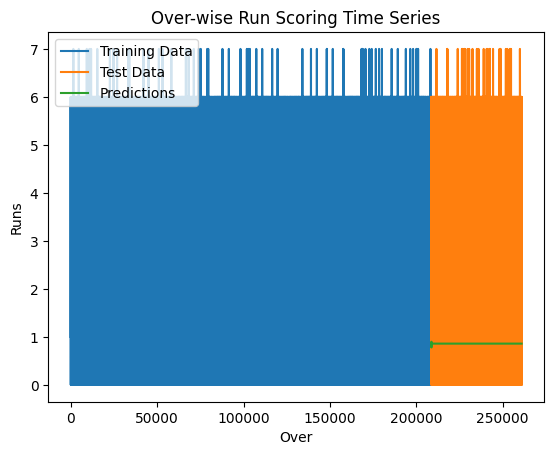

In [139]:
#14. Can you model run scoring as a time series (over-wise or ball-wise)? Try using LSTM or ARIMA.
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

X = df2['total_runs']  # Time series data
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)  # Ensure time series is not shuffled
model = sm.tsa.arima.ARIMA(X_train, order=(5, 1, 0))  # Example order
model_fit = model.fit()
predictions = model_fit.predict(start=len(X_train), end=len(X) - 1)

#  Forecasting and Evaluation
rmse = mean_squared_error(X_test, predictions)
print(f'RMSE: {rmse}')

#  Visualization
plt.plot(X_train.index, X_train, label='Training Data')
plt.plot(X_test.index, X_test, label='Test Data')
plt.plot(X_test.index, predictions, label='Predictions')
plt.title('Over-wise Run Scoring Time Series')
plt.xlabel('Over')
plt.ylabel('Runs')
plt.legend()
plt.show()

In [154]:
df2

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NA,NA,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,NA,NA,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NA,NA,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,NA,NA,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,NA,NA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,,0,NA,NA,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,,0,NA,NA,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,,0,NA,NA,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,,0,NA,NA,NaN


In [164]:
df2.columns = df2.columns.str.strip()

In [165]:
#15. How would you implement a rolling average or exponential moving average of batsman performance for use as features in a predictive model?
Batsman_df = (
    df2.groupby(['match_id','batter'])
      .agg(
          runs_scored=('batsman_runs', 'sum'),
          balls_faced=('ball','count'),
      )
      .reset_index()
      .rename(columns={'batter': 'player'})
)

In [166]:
Batsman_df['rolling_avg_3'] = (
    Batsman_df.groupby('player')['runs_scored']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

In [167]:
Batsman_df.head()

,match_id,player,runs_scored,balls_faced,rolling_avg_3
0,335982,AA Noffke,9,12,9.0
1,335982,B Akhil,0,2,0.0
2,335982,BB McCullum,158,77,158.0
3,335982,CL White,6,10,6.0
4,335982,DJ Hussey,12,12,12.0


In [168]:
Batsman_df=Batsman_df.drop(['balls_faced'],axis=1)
Batsman_df=Batsman_df.sort_values(by=['player','match_id']).reset_index(drop=True)
Batsman_df.head()

,match_id,player,runs_scored,rolling_avg_3
0,548346,A Ashish Reddy,10,10.000000
1,548352,A Ashish Reddy,3,6.500000
2,548359,A Ashish Reddy,8,7.000000
3,548373,A Ashish Reddy,10,7.000000
4,548376,A Ashish Reddy,4,7.333333


In [170]:
Batsman_df['rolling_avg_3'] = (
    Batsman_df.groupby('player')['runs_scored']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

Batsman_df['ema_runs'] = (
    Batsman_df.groupby('player')['runs_scored']
    .transform(lambda x: x.ewm(span=3, adjust=False).mean())
)

Batsman_df['target_runs_next_match'] = (
    Batsman_df.groupby('player')['runs_scored'].shift(-1)
)

Batsman_df=Batsman_df.drop(['match_id'],axis=1)

Batsman_df.head()

,player,runs_scored,rolling_avg_3,ema_runs,target_runs_next_match
0,A Ashish Reddy,10,10.000000,10.0000,3.0
1,A Ashish Reddy,3,6.500000,6.5000,8.0
2,A Ashish Reddy,8,7.000000,7.2500,10.0
3,A Ashish Reddy,10,7.000000,8.6250,4.0
4,A Ashish Reddy,4,7.333333,6.3125,7.0


In [171]:
#Convert playername to playerid


# Create dictionary: {player_name: unique_id}
player_to_id = {name: idx for idx, name in enumerate(Batsman_df['player'].unique())}

print(player_to_id)

Batsman_df['player_id'] = Batsman_df['player'].map(player_to_id)

Batsman_df=Batsman_df.drop(['player','runs_scored'],axis=1)
Batsman_df.isnull().sum()

{'A Ashish Reddy          ': 0, 'A Badoni                ': 1, 'A Chandila              ': 2, 'A Chopra                ': 3, 'A Choudhary             ': 4, 'A Dananjaya             ': 5, 'A Flintoff              ': 6, 'A Kamboj                ': 7, 'A Kumble                ': 8, 'A Manohar               ': 9, 'A Mishra                ': 10, 'A Mithun                ': 11, 'A Mukund                ': 12, 'A Nehra                 ': 13, 'A Nortje                ': 14, 'A Raghuvanshi           ': 15, 'A Singh                 ': 16, 'A Symonds               ': 17, 'A Tomar                 ': 18, 'A Uniyal                ': 19, 'A Zampa                 ': 20, 'AA Bilakhia             ': 21, 'AA Chavan               ': 22, 'AA Jhunjhunwala         ': 23, 'AA Kulkarni             ': 24, 'AA Noffke               ': 25, 'AB Agarkar              ': 26, 'AB Barath               ': 27, 'AB Dinda                ': 28, 'AB McDonald             ': 29, 'AB de Villiers          ': 30, 'AC Blizzard     

,0
rolling_avg_3,0
ema_runs,0
target_runs_next_match,673
player_id,0


In [172]:
Batsman_df = Batsman_df.dropna(subset=['target_runs_next_match'])

Batsman_df.isnull().sum()

,0
rolling_avg_3,0
ema_runs,0
target_runs_next_match,0
player_id,0


In [187]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score


scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(Batsman_df)

# Convert back to DataFrame
Batsman_df = pd.DataFrame(scaled_array, columns=Batsman_df.columns, index=Batsman_df.index)

Batsman_df.head()
# Features and target
X = Batsman_df[['rolling_avg_3', 'ema_runs']]
y = Batsman_df['target_runs_next_match']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model_player_avg = RandomForestRegressor()
model_player_avg.fit(X_train, y_train)

# Predict
y_pred = model_player_avg.predict(X_test)

# 5-Fold Cross Validation on Regression Problem
scores = cross_val_score(model_player_avg, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Neg Mean absolute error after cross validation : "+str(-scores))
# Evaluate
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Neg Mean absolute error after cross validation : [0.0998249  0.09782205 0.09348002 0.09864181 0.09987807]
MAE: 0.09531194486510462
R² Score: -0.15571002482360918


In [186]:
df2 = df2.map(lambda x: x.strip() if isinstance(x, str) else x)
df2 = df2.map(lambda x: "" if str(x).strip().upper() == "NA" else x)

In [188]:
def next_match_Score(player_name):
  player_id=player_to_id[player_name]
  print(player_id)
  player_rolling_avg= Batsman_df[Batsman_df['player_id'] == player_id]['rolling_avg_3'].mean()
  player_ema_runs=Batsman_df[Batsman_df['player_id'] == player_id]['ema_runs'].mean()
  new_data = pd.DataFrame({
      'rolling_avg_3': [player_rolling_avg],
      'ema_runs': [player_ema_runs],
  })
  y_pred = model_player_avg.predict(X_test)
  return y_pred[0]

In [189]:
df2

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,,,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,,,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,,,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,,,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,,0,,,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,,0,,,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,,0,,,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,,0,,,NaN


In [190]:
df2 = df2.map(lambda x: x.strip() if isinstance(x, str) else x)
df2 = df2.map(lambda x: "" if str(x).strip().upper() == "NA" else x)

In [191]:
player_name="BB McCullum"
print("How much runs" + player_name + " will score in next match? " + str(next_match_Score(player_name)))

KeyError: 'BB McCullum'